# xG data exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('df.csv')

/home/elgutto/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,45,74,75,76,77,80,81,84,85,86,87,89,90,95,96,97,99,101,102,103,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
df

In [2]:
from pathlib import Path

root = Path('.')

[x for x in root.iterdir() if x.is_dir()]

[PosixPath('statsbomb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('d3exploration'),
 PosixPath('.git')]

In [3]:
len(list(root.glob('**/events/*.json')))

890

In [4]:
N = 445
dfs = []
for file in tqdm(list(root.glob('**/events/*.json'))):
    with file.open() as f:
        df = pd.json_normalize(json.loads(f.read()), sep='_')
    dfs.append(df)
df = pd.concat(dfs, sort=False)
df.reset_index(drop=True, inplace=True)
df.to_csv('df.csv')

100%|██████████| 890/890 [06:09<00:00,  2.41it/s]


## Data preparation

In [2]:
COMP_ID = 43
SEASON_ID = 3

with open(f'statsbomb/data/matches/{COMP_ID}/{SEASON_ID}.json') as f:
    data = json.load(f)
matches = [row['match_id'] for row in data]

In [3]:
dfs = []
for match in tqdm(matches):
    with open(f'statsbomb/data/events/{match}.json') as f:
        df = pd.json_normalize(json.loads(f.read()), sep='_')
    dfs.append(df)
df = pd.concat(dfs, sort=False)
df.reset_index(drop=True, inplace=True)
print('lol')

100%|██████████| 64/64 [00:25<00:00,  2.50it/s]


lol


In [4]:
# shots = df[df.type_name == 'Shot']
shots = df.query('type_name == "Shot"')

In [5]:
pd.options.mode.chained_assignment = None
def parse_shots(shots):
    columns = ['x', 'y', 'head', 'phase', 'statsbombxg', 'outcome']
    
    shots['head'] = 1 * (shots.shot_body_part_name == 'Head')
    shots[['x', 'y']] = pd.DataFrame(shots.location.to_list(), index=shots.index)
    shots.x = (shots.x / 120 * 105).astype(int)
    shots.y = (shots.y / 80 * 68).astype(int)
    #pd.DataFrame(features.location.to_list(), index=features.index)
    
    shots['phase'] = shots.shot_type_name
    shots['statsbombxg'] = shots.shot_statsbomb_xg
    shots['outcome'] = 1 * (shots.shot_outcome_name == 'Goal')
    
    shots.drop(shots.columns.difference(columns), axis=1, inplace=True)
    shots = shots[shots.phase == 'Open Play']
    shots.reset_index(drop=True, inplace=True)
    
    return shots

In [6]:
shots = parse_shots(shots)

In [10]:
def distance_to_goal(origin):
    dest = np.array([105., 34.])
    return np.sqrt(np.sum((origin - dest) ** 2))

def goal_angle(origin):
    p0 = np.array((105., 34 - 7.32 / 2))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((105., 34 + 7.32 / 2))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

shots['distance_to_goal'] = shots.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
shots['goal_angle'] = shots.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)
shots['logdist'] = np.log(shots.distance_to_goal)
shots['logangle'] = np.log(shots.goal_angle)

In [11]:
#shots.hist(bins=50, figsize=(20, 12))

In [12]:
shots

,head,x,y,phase,statsbombxg,outcome,distance_to_goal,goal_angle,logdist,logangle
0,0,100,28,Open Play,0.074087,1,7.810250,0.655448,2.055437,-0.422436
1,0,98,30,Open Play,0.292995,1,8.062258,0.781855,2.087194,-0.246086
2,0,90,20,Open Play,0.028038,0,20.518285,0.263133,3.021316,-1.335096
3,0,84,31,Open Play,0.064261,0,21.213203,0.338527,3.054624,-1.083151
4,0,97,42,Open Play,0.303150,0,11.313708,0.472389,2.426015,-0.749952
...,...,...,...,...,...,...,...,...,...,...
1551,1,98,34,Open Play,0.055357,0,7.000000,0.963531,1.945910,-0.037150
1552,1,92,34,Open Play,0.016941,0,13.000000,0.548869,2.564949,-0.599895
1553,0,92,51,Open Play,0.027727,0,21.400935,0.210852,3.063435,-1.556600
1554,0,81,36,Open Play,0.020467,0,24.083189,0.300658,3.181514,-1.201781


## Fitting and evaluation

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score

train_set, test_set = train_test_split(shots, test_size=0.2, random_state=9)

In [14]:
len(train_set), len(test_set)

(1244, 312)

In [16]:
#features = ['x', 'y']

#features = ['distance_to_goal', 'goal_angle']
features = ['x', 'y', 'distance_to_goal', 'goal_angle']

X_train = train_set[features]
y_train = train_set.outcome
X_test = test_set[features]
y_test = test_set.outcome

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

predictions = pipe.predict_proba(X_test)[:, 1]
accuracy = (predictions == y_test).mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.00


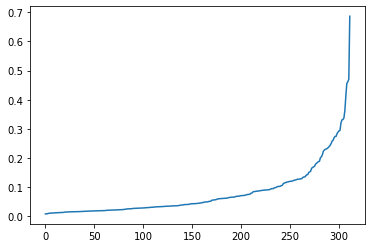

In [19]:

plt.plot(sorted(test_set.statsbombxg))

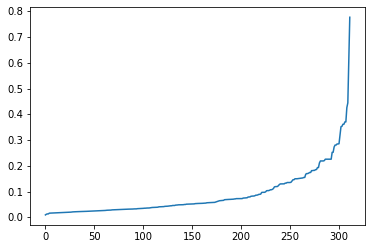

In [20]:

plt.plot(sorted(predictions))

In [21]:
from joblib import dump, load
dump(pipe, 'model.joblib') 

['model.joblib']

In [22]:
def eval_features(features, train_set, test_set):
    sbxg = test_set.statsbombxg
    sb_outcome = 1 * (sbxg > 0.5)
    
    X_train = train_set[features]
    y_train = train_set.outcome
    X_test = test_set[features]
    y_test = test_set.outcome
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    
    predictions = pipe.predict(X_test)
    accuracy = (predictions == y_test).mean()
    print(f'Accuracy: {accuracy:.2f}')
    sb_acc = (sb_outcome == y_test).mean()
    
    prob_predictions = pipe.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test, prob_predictions)
    print(f'Brier Score: {brier_score:.2f}')
    sb_brier = brier_score_loss(y_test, sbxg)
    
    auc_score = roc_auc_score(y_test, prob_predictions)
    print(f'AUC score: {auc_score:.2f}')
    
    auc_score = roc_auc_score(y_test, sbxg)
    print(f'Statsbomb accuracy: {sb_acc:.2f}')
    print(f'Statsbomb Brier Score: {sb_brier:.2f}')
    print(f'Statsbomb AUC score: {auc_score:.2f}')
    print()

In [23]:
features = ['x', 'y']
eval_features(features, train_set, test_set)
features = ['distance_to_goal', 'goal_angle']
eval_features(features, train_set, test_set)
features = ['logdist', 'logangle']
eval_features(features, train_set, test_set)
features = ['logdist', 'goal_angle']
eval_features(features, train_set, test_set)
features = ['x', 'y', 'distance_to_goal', 'goal_angle']
eval_features(features, train_set, test_set)

Accuracy: 0.93
Brier Score: 0.07
AUC score: 0.68
Statsbomb accuracy: 0.92
Statsbomb Brier Score: 0.07
Statsbomb AUC score: 0.73

Accuracy: 0.92
Brier Score: 0.07
AUC score: 0.68
Statsbomb accuracy: 0.92
Statsbomb Brier Score: 0.07
Statsbomb AUC score: 0.73

Accuracy: 0.92
Brier Score: 0.07
AUC score: 0.68
Statsbomb accuracy: 0.92
Statsbomb Brier Score: 0.07
Statsbomb AUC score: 0.73

Accuracy: 0.92
Brier Score: 0.07
AUC score: 0.68
Statsbomb accuracy: 0.92
Statsbomb Brier Score: 0.07
Statsbomb AUC score: 0.73

Accuracy: 0.92
Brier Score: 0.07
AUC score: 0.68
Statsbomb accuracy: 0.92
Statsbomb Brier Score: 0.07
Statsbomb AUC score: 0.73

